# NLP Introduction Notebook

In this notebook we'll revise a brief introduction into Natural Language Processing using Python.

## Python libraries for NLP

There exist a few main librarires to perform NLP, those are: Wordcloud, Spacy and NLTK, so we'll first install them in our environment in the following cell. Note that for spacy we dowload english language models, those will help us in analysing Part-Of-Speech, Named Entity Recognition, Lemmatizing, and more, which we'll explain further in this notebook.

Note: If the following cell is still not installing the libraries in your environment, you can run them from the terminal (without the '!').

You can read more about them in the following links:
- Spacy: https://spacy.io/api/doc/
- NLTK: https://www.nltk.org/
- Wordcloud: https://amueller.github.io/word_cloud/

Important: if there's any trouble opening this notebook, use: 'conda install -c conda-forge jupyter_contrib_nbextensions '

In [1]:
# Uncomment the following lines for installing the Spacy and NLTK libraries.
# ! pip install pandas
# ! pip install wordcloud
# ! pip install nltk
# ! pip install spacy
# ! pip install pyldavis
# ! pip install gensim
# ! pip install yellowbrick
# ! python -m spacy download en_core_web_sm
# ! python -m spacy download en_core_web_md
# ! python -m spacy download en_core_web_lg

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [7]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we can import the libraries. We'll also be using pandas for data importation and manipulation, and matplotlib for visualization.

In [3]:
# Data wrangling and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

# Text mining
from gensim import models, corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pyLDAvis.gensim
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import re
import time
# nltk.download('punkt') # Uncomment this line if using for the first time the NLTK library
# nltk.download('stopwords') # Uncomment this line if using for the first time the NLTK library

In this notebook we'll be working with the following dataset, which contains information about reviews on Amazon products: https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products.

We will start by importing the '1429_1.csv' file which is the smallest of the three files downloaded from the Kaggle link above.

In [4]:
df = pd.read_csv("../data/archive/1429_1.csv", encoding="utf-8")

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can observe that the amount of columns may serve for multiple types of analysis of sales on the Amazon products. For the sake of this notebook we'll focus in those that represent text information.

In [9]:
df = df[["name", "brand", "categories", "manufacturer", "reviews.date", "reviews.rating", "reviews.text", "reviews.title"]]

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The dataset covers many products, we can see the most reviewed ones in the following cell.

In [10]:
df[["name", "reviews.text"]].groupby(["name"]).count().sort_values(["reviews.text"], ascending=False).head()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviews.text
name,
"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",10966
"Echo (White),,,\r\nEcho (White),,,",3309
"Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,",3176
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",2814
"Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",2527


We'll focus on only the rating, text and title fields.

In [11]:
# df_most_reviews = df[df["name"] == "Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta"]
df = df[["reviews.rating", "reviews.text", "reviews.title"]]
df.columns = ['rating', 'text', 'title']
df = df.dropna()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In case of wanting to run the notebook faster, optionally we can grab a sample with a smaller amount of rows.

In [12]:
# df = df.sample(n=2000, random_state=1)

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The count of reviews grouped by rating:

In [13]:
df[["rating", "text"]].groupby(["rating"]).count()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
rating,
1.0,410
2.0,402
3.0,1499
4.0,8541
5.0,23769


## Text Distribution

We can visualize the length of a set of texts, which first we need to get the count of words in each of the analyzed texts.

In [14]:
lista_title_count = []
lista_text_count = []
for index, row in df.iterrows():
    title_count = 0
    text_count = 0
    title_count=len((str(row['title'])))
    text_count=len((str(row['text'])))
    lista_title_count.append(title_count)
    lista_text_count.append(text_count)
    
df['title_count'] = lista_title_count
df['text_count'] = lista_text_count

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
df.head()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rating,text,title,title_count,text_count
0,5.0,This product so far has not disappointed. My c...,Kindle,6,143
1,5.0,great for beginner or experienced person. Boug...,very fast,9,75
2,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,39,131
3,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,7,593
4,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,25,613


Before moving on into more specific analysis, first we will set every text to lowercase.

In [16]:
df["text"] = df["text"].str.lower()
df["title"] = df["title"].str.lower()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In the next plot, we can visualize how an average of reviews are found to have from 10 to 30 words in the title.

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


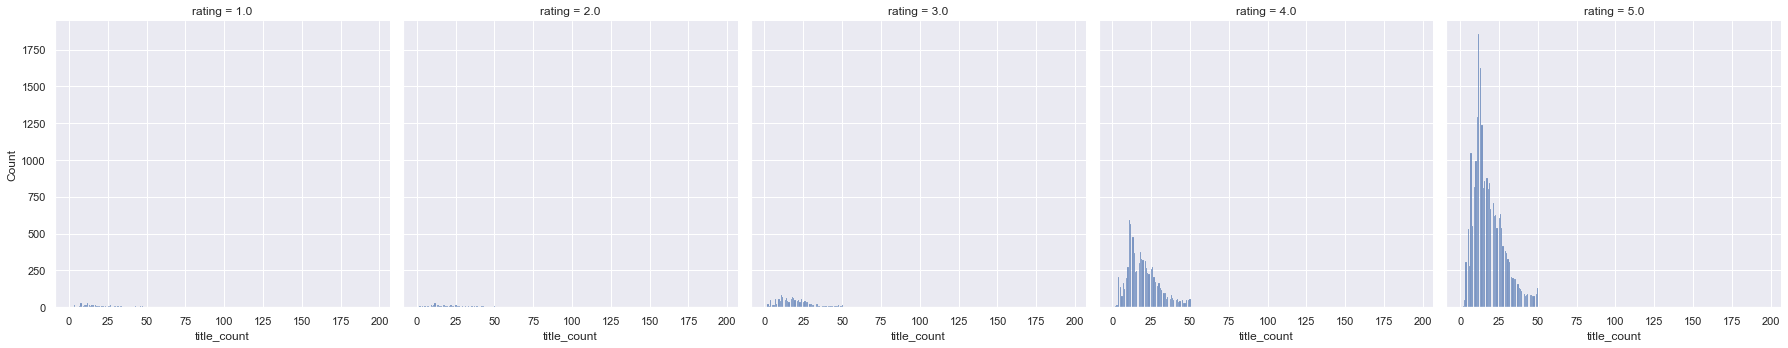

In [17]:
sns.set(rc={'figure.figsize':(12,8)})
sns.displot(df, x="title_count", col="rating")

In the next plot, we can visualize the distribution for the body texts on the reviews.

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


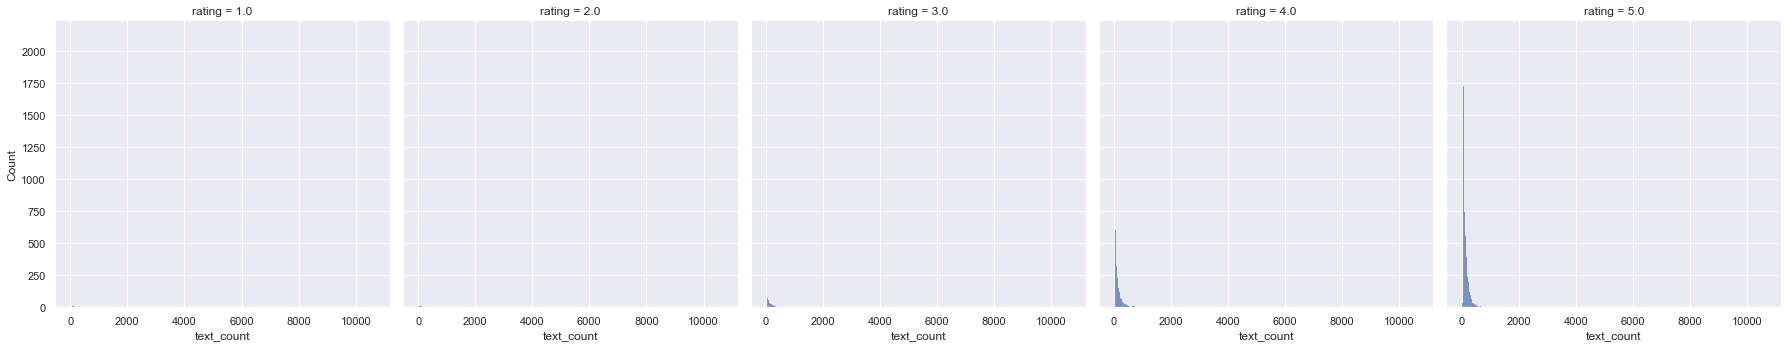

In [18]:
sns.displot(df, x="text_count", col="rating")

In the plot above we can observe that there are some reviews that are too long, we can prove that there exist these outlier reviews by plotting a box plot.

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='rating', ylabel='text_count'>

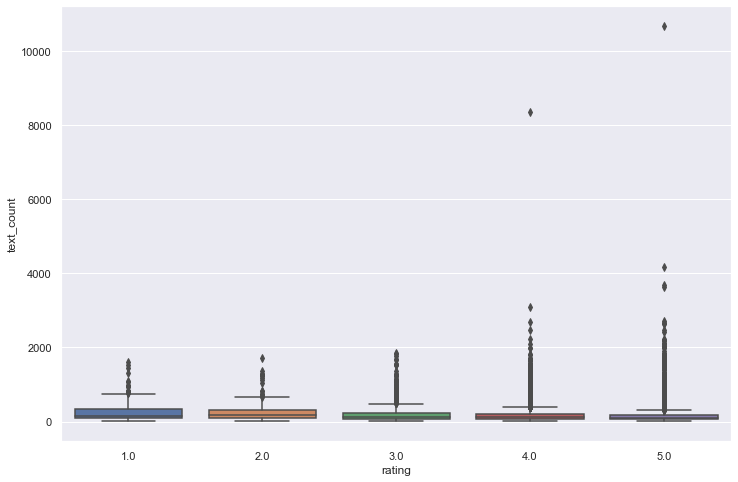

In [19]:
sns.boxplot(x="rating", y="text_count", data=df)

## Wordclouds

A wordcloud may give insight into which words are mentioned the most in a set of texts, as shown in the following example wordcloud:
<p></p>
<div>
<img src="wordcloud_example.jpg" width="500"/>
</div>

For the titles of each review we can obtain the wordcloud as shown below:

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hay 693481 palabras en titulos.


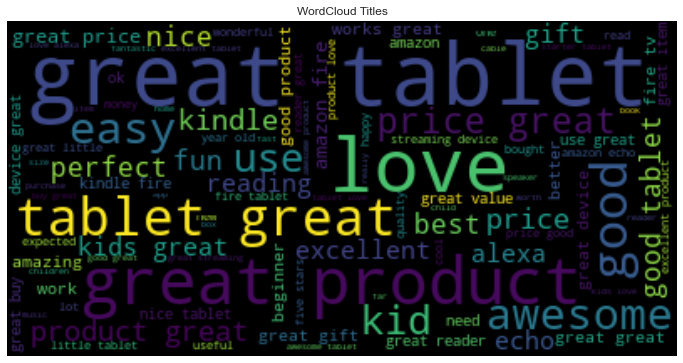

In [20]:
# Parse all the rows into a single string
title_text = " ".join(text for text in df["title"])
print ("Hay {} palabras en titulos.".format(len(title_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(title_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Titles")
plt.show()

More specifically, we could observe what the wordcloud would be like for each of the ratings in the reviews:

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hay 8945 palabras en titulos.


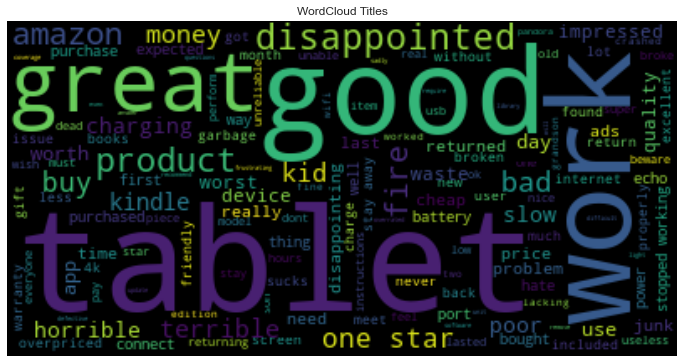

In [21]:
rating = 1.0
# Parse all the rows into a single string
title_text = " ".join(text for text in df[df["rating"] == rating]["title"])
print ("Hay {} palabras en titulos.".format(len(title_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(title_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Titles")
plt.show()

Following the same process, we can apply the same function to the reviews body texts.

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hay 5510782 palabras en textos.


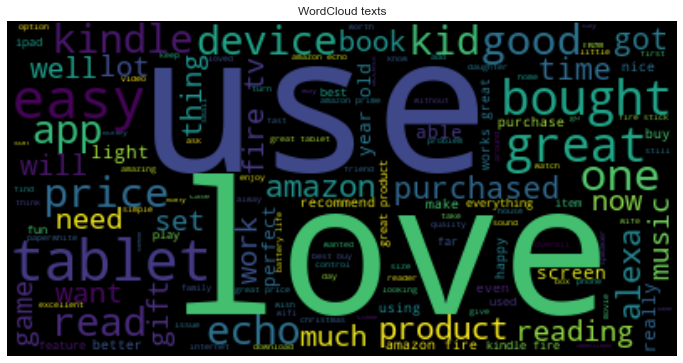

In [22]:
# Parse all the rows into a single string
body_text = " ".join(text for text in df["text"])
print ("Hay {} palabras en textos.".format(len(body_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(body_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud texts")
plt.show()

We can perform the same rating-specific approach as with the titles.

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hay 102622 palabras en textos.


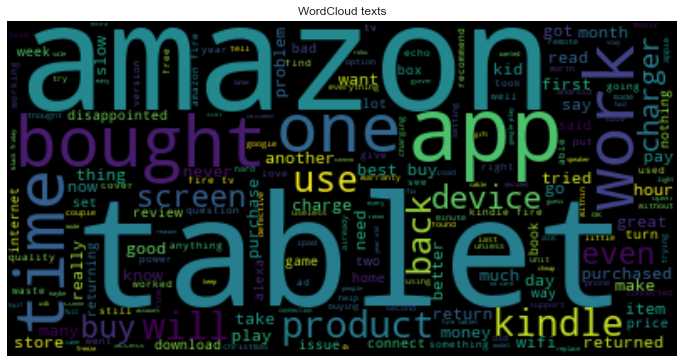

In [23]:
rating = 1.0
# Parse all the rows into a single string
body_text = " ".join(text for text in df[df["rating"] == rating]["text"])
print ("Hay {} palabras en textos.".format(len(body_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(body_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud texts")
plt.show()

## Most frequent words

Now we will introduce a couple of useful functions. 

We will being by assigning the stopwords information into the sw variable.

In [24]:
sw = stopwords.words("english")

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


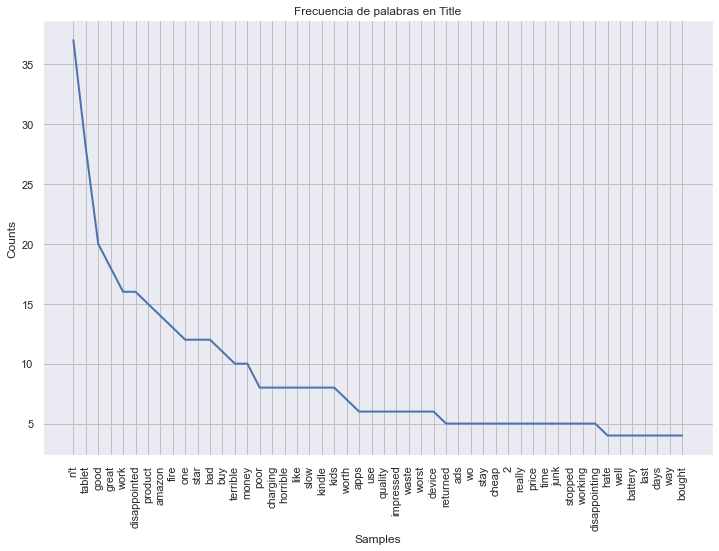

<AxesSubplot:title={'center':'Frecuencia de palabras en Title'}, xlabel='Samples', ylabel='Counts'>

In [25]:
rating = 1.0
if rating == None:
    words = " ".join(text for text in df["title"])
else:
    words = " ".join(text for text in df[df["rating"] == rating]["title"])
words = nltk.word_tokenize(words)
words = [word for word in words if word not in sw and re.match('([a-zA-Z0-9]+)',word)]
freqdist = nltk.FreqDist(words)
plt.figure(figsize=(12,8))
plt.title("Frecuencia de palabras en Title")
freqdist.plot(50)

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


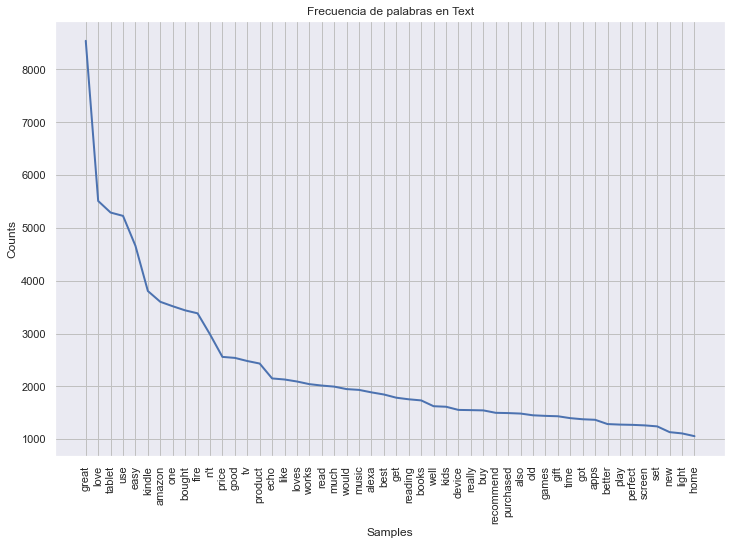

<AxesSubplot:title={'center':'Frecuencia de palabras en Text'}, xlabel='Samples', ylabel='Counts'>

In [26]:
rating = 5.0
if rating == None:
    words = " ".join(text for text in df["text"])
else:
    words = " ".join(text for text in df[df["rating"] == rating]["text"])
words = nltk.word_tokenize(words)
words = [word for word in words if word not in sw and re.match('([a-zA-Z0-9]+)',word)]
freqdist = nltk.FreqDist(words)
plt.figure(figsize=(12,8))
plt.title("Frecuencia de palabras en Text")
freqdist.plot(50)

## Sentiment Analysis

Ratings of 1.0, 2.0, 3.0 may be considered bad.
Ratings of 4.0, 5.0 may be considered good.

We begin by initializing the sentiment analyzer.

In [27]:
analyser = SentimentIntensityAnalyzer()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
def sentiment_analyzer_scores(sentence, show = False):
    score = analyser.polarity_scores(sentence)
    if show:
        print("{:-<40} {}".format(sentence, str(score)))
    return score

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
score = sentiment_analyzer_scores("I think the movie was amazing!.", True)
type(score)

I think the movie was amazing!.--------- {'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compound': 0.6239}


C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict

In [30]:
lista_sentiment_neg = []
lista_sentiment_neu = []
lista_sentiment_pos = []
lista_sentiment_comp = []

for index, row in enumerate(df.itertuples(), 1):
    sentiment = sentiment_analyzer_scores(row.text)
    lista_sentiment_neg.append(sentiment['neg'])
    lista_sentiment_neu.append(sentiment['neu'])
    lista_sentiment_pos.append(sentiment['pos'])
    lista_sentiment_comp.append(sentiment['compound'])

df['sentiment_neg'] = lista_sentiment_neg
df['sentiment_neu'] = lista_sentiment_neu
df['sentiment_pos'] = lista_sentiment_pos
df['sentiment_comp'] = lista_sentiment_comp

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
df.head()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rating,text,title,title_count,text_count,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_comp
0,5.0,this product so far has not disappointed. my c...,kindle,6,143,0.000,0.610,0.390,0.9194
1,5.0,great for beginner or experienced person. boug...,very fast,9,75,0.000,0.507,0.493,0.8934
2,5.0,inexpensive tablet for him to use and learn on...,beginner tablet for our 9 year old son.,39,131,0.000,0.896,0.104,0.4404
3,4.0,i've had my fire hd 8 two weeks now and i love...,good!!!,7,593,0.035,0.698,0.267,0.9875
4,5.0,i bought this for my grand daughter when she c...,fantastic tablet for kids,25,613,0.000,0.918,0.082,0.7876


C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='rating', ylabel='sentiment_comp'>

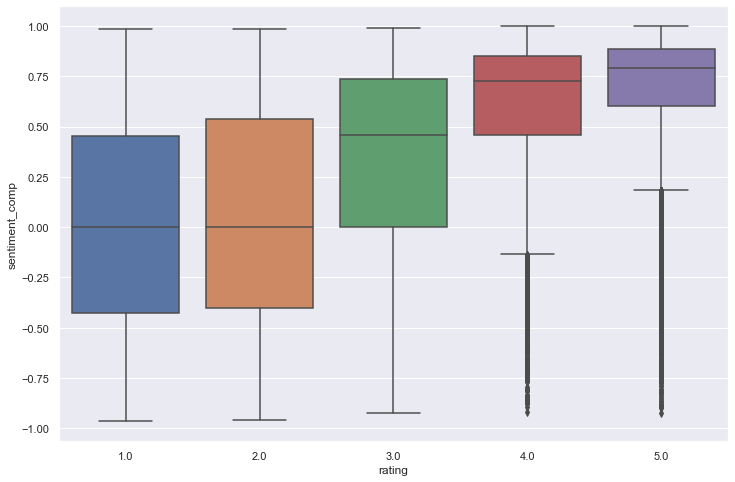

In [32]:
sns.boxplot(data=df, x='rating', y='sentiment_comp')

## Tokenization

In [33]:
lista_tokens = []

for index, row in enumerate(df.itertuples(), 1):
    sentence = row.text
    tokens = nltk.word_tokenize(sentence)
    lista_tokens.append(tokens)
    
df['tokens_text'] = lista_tokens

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
df['tokens_text'].head()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [this, product, so, far, has, not, disappointe...
1    [great, for, beginner, or, experienced, person...
2    [inexpensive, tablet, for, him, to, use, and, ...
3    [i, 've, had, my, fire, hd, 8, two, weeks, now...
4    [i, bought, this, for, my, grand, daughter, wh...
Name: tokens_text, dtype: object

## Text Cleaning

...

In [35]:
df['text_lemma'] = df['text'].str.strip()
df['text_lemma'] = df['text_lemma'].str.strip()
df['text_lemma'] = df['text_lemma'].str.lower()
df['text_lemma'] = df['text_lemma'].str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Stemming

In [36]:
stemmer = SnowballStemmer(language='english')

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
lista_text_stem = []

for index, row in enumerate(df.itertuples(), 1):
    tokens = row.tokens_text
    stems = []
    for token in tokens:
        stem = stemmer.stem(token)
        if len(stem) > 0:
            stems.append(stem)
    text_stem = " ".join(text for text in stems)
    lista_text_stem.append(text_stem)
    
df['text_stem'] = lista_text_stem

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
df['text_stem'].head()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    this product so far has not disappoint . my ch...
1    great for beginn or experienc person . bought ...
2    inexpens tablet for him to use and learn on , ...
3    i ve had my fire hd 8 two week now and i love ...
4    i bought this for my grand daughter when she c...
Name: text_stem, dtype: object

### Lemmatization

In [39]:
nlp = spacy.load('en_core_web_md')

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
demo_text = "The red fox jumps through the wall and hides beneath the tree."

for token in nlp(demo_text):
    print(f"{'token: ' + str(token):<15} - {'lemma: ' + token.lemma_:<15} - {'pos: ' + token.pos_:<10} - {'ent: ' + token.ent_type_:<10}")

token: The      - lemma: the      - pos: DET   - ent:      
token: red      - lemma: red      - pos: ADJ   - ent:      
token: fox      - lemma: fox      - pos: NOUN  - ent:      
token: jumps    - lemma: jump     - pos: VERB  - ent:      
token: through  - lemma: through  - pos: ADP   - ent:      
token: the      - lemma: the      - pos: DET   - ent:      
token: wall     - lemma: wall     - pos: NOUN  - ent:      
token: and      - lemma: and      - pos: CCONJ - ent:      
token: hides    - lemma: hide     - pos: VERB  - ent:      
token: beneath  - lemma: beneath  - pos: ADP   - ent:      
token: the      - lemma: the      - pos: DET   - ent:      
token: tree     - lemma: tree     - pos: NOUN  - ent:      
token: .        - lemma: .        - pos: PUNCT - ent:      


C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
demo_text = "Michael Jordan talked with Nike about a new deal worth $1B USD!"

for token in nlp(demo_text):
    print(f"{'token: ' + str(token):<15} - {'lemma: ' + token.lemma_:<15} - {'pos: ' + token.pos_:<10} - {'ent: ' + token.ent_type_:<10}")

token: Michael  - lemma: Michael  - pos: PROPN - ent: PERSON
token: Jordan   - lemma: Jordan   - pos: PROPN - ent: PERSON
token: talked   - lemma: talk     - pos: VERB  - ent:      
token: with     - lemma: with     - pos: ADP   - ent:      
token: Nike     - lemma: Nike     - pos: PROPN - ent: ORG  
token: about    - lemma: about    - pos: ADP   - ent:      
token: a        - lemma: a        - pos: DET   - ent:      
token: new      - lemma: new      - pos: ADJ   - ent:      
token: deal     - lemma: deal     - pos: NOUN  - ent:      
token: worth    - lemma: worth    - pos: ADJ   - ent:      
token: $        - lemma: $        - pos: SYM   - ent: MONEY
token: 1B       - lemma: 1B       - pos: PROPN - ent: MONEY
token: USD      - lemma: USD      - pos: PROPN - ent: MONEY
token: !        - lemma: !        - pos: PUNCT - ent:      


C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
lista_text_lemma = []

for sentence in list(nlp.pipe(df['text'], disable=['ner', 'parser'])):
    lemmas = []
    for token in sentence:
        lemma = str(token.lemma_)
        if (len(lemma) > 0) and (lemma != '-PRON-') and (lemma not in sw) and (re.match('([a-zA-Z]+)',token.text) != None):
            lemmas.append(lemma)
    text_lemma= " ".join(text for text in lemmas)
    lista_text_lemma.append(text_lemma)
    
df['text_lemma'] = lista_text_lemma

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
df['text_lemma'].head()

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    product far disappoint child love use like abi...
1      great beginner experienced person buy gift love
2    inexpensive tablet use learn step nabi thrille...
3    fire hd two week love tablet great value.we pr...
4    buy grand daughter come visit set user enter a...
Name: text_lemma, dtype: object

## Topic Modeling

What are the main topics of the reviews?
Quick LDA and pyLDAvis

In [44]:
def train_lda(data, num_topics=10):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    chunksize = 300
    tokenized = []
    for doc in list(nlp.pipe(df['text_lemma'], disable=['ner', 'parser'])):
        tokens = []
        for token in doc:
            tokens.append(token.text)
        tokenized.append(tokens)
    dictionary = corpora.Dictionary(tokenized)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
dictionary,corpus,lda = train_lda(df, num_topics=5)

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time to train LDA model on  34621 articles:  0.3028615673383077 min


In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.028718  0.255443       1        1  31.122170
1     -0.128467 -0.029534       2        1  22.263244
3      0.120502 -0.142087       3        1  16.850552
2      0.233472 -0.031408       4        1  15.963382
4     -0.254225 -0.052413       5        1  13.800652, topic_info=          Term          Freq         Total Category  logprob  loglift
419         tv  14839.000000  14839.000000  Default  30.0000  30.0000
40        fire  14066.000000  14066.000000  Default  29.0000  29.0000
835  streaming   4854.000000   4854.000000  Default  28.0000  28.0000
640        box   4762.000000   4762.000000  Default  27.0000  27.0000
146     kindle   4003.000000   4003.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
142     device    677.339333   5375.653913   Topic5  -4.6544  -0.0910
93        make    564.990848   2832.106165   Topic5  -4.8358   0.3685
74      amazon    569.423352  10140.494005   Topic5  -4.8279  -0.8992
125         go    527.675141   2768.891173   Topic5  -4.9041   0.3227
171       want    528.693794   3422.665672   Topic5  -4.9022   0.1127

[330 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
775       4  1.000692  absolutely
28        1  0.181781      access
28        2  0.818016      access
306       1  1.000332     account
678       3  0.999898         add
...     ...       ...         ...
121       4  0.161451       would
905       4  0.998366       wrong
122       1  0.858490        year
122       3  0.001337        year
122       5  0.139739        year

[454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

## Clustering

K-Means with silhouette score and more.

In [48]:
from nltk.cluster import KMeansClusterer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
encode = CountVectorizer(binary=True)
freqs = encode.fit_transform(df['text'])
vect = [freq.toarray()[0] for freq in freqs]

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
model = KMeansClusterer(5, nltk.cluster.util.cosine_distance, avoid_empty_clusters = True)

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
clusters = model.cluster(vect, True, trace=True)

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [57]:
print("Clustered:", vect)
print("As:", clusters)
print("Means:", model.means())

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Clustered: [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [59]:
df['clusters_nltk_cos'] = clusters 

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
df.to_csv("results.csv", index=False)

C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\rolan\.conda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\rolan\.conda\envs\nlp\lib\site-packages\yellowbrick\base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


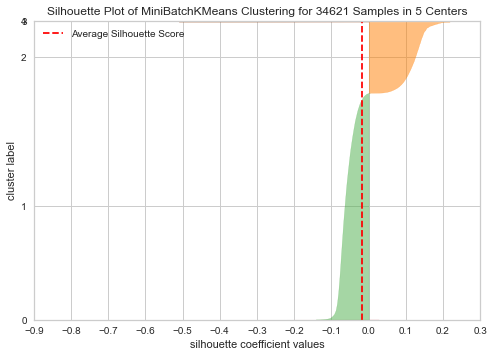

<AxesSubplot:title={'center':'Silhouette Plot of MiniBatchKMeans Clustering for 34621 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [88]:
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import SilhouetteVisualizer
import numpy

# list_to_vis = []
# for index, row in enumerate(df.itertuples(), 1):
#     if len(row.text_lemma) > 0:
#         list_to_vis.append(row.text_lemma)
# 
# print(len(list_to_vis))

bow = CountVectorizer(strip_accents="ascii")
X_bow = bow.fit_transform(df.text_lemma)
        
visualizer = SilhouetteVisualizer(MiniBatchKMeans(n_clusters=5, random_state=0, batch_size=6))
visualizer.fit(X_bow)
visualizer.poof()

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=[4,10])
visualizer.fit(X_bow)
visualizer.poof()